In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

In [4]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [5]:
device = set_device()

GPU is enabled in this notebook.


In [6]:
# Create folder with training, testing and validation data.

spectrograms_dir = "/content/drive/MyDrive/Data/Data/images_original/"
folder_names = ['/content/drive/MyDrive/Data/train/', '/content/drive/MyDrive/Data/test/', '/content/drive/MyDrive/Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [7]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

In [8]:
# Set the desired image size
image_size = (128, 128)

# Set the batch size and number of epochs
batch_size = 32
epochs = 50

# Create data generators with data augmentation for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 745 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [9]:
# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
             steps_per_epoch=train_generator.samples // batch_size,
             epochs=epochs,
             validation_data=valid_generator,
             validation_steps=valid_generator.samples // batch_size)


# Access the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical')
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/50
23/23 [==============================] - 18s 331ms/step - loss: 2.2970 - accuracy: 0.1108 - val_loss: 2.2956 - val_accuracy: 0.1562
Epoch 2/50
23/23 [==============================] - 6s 252ms/step - loss: 2.2889 - accuracy: 0.1304 - val_loss: 2.2868 - val_accuracy: 0.1562
Epoch 3/50
23/23 [==============================] - 7s 303ms/step - loss: 2.2796 - accuracy: 0.1332 - val_loss: 2.2716 - val_accuracy: 0.1250
Epoch 4/50
23/23 [==============================] - 7s 315ms/step - loss: 2.2706 - accuracy: 0.1431 - val_loss: 2.2593 - val_accuracy: 0.1458
Epoch 5/50
23/23 [==============================] - 6s 255ms/step - loss: 2.2719 - accuracy: 0.1150 - val_loss: 2.2417 - val_accuracy: 0.2396
Epoch 6/50
23/23 [==============================] - 7s 313ms/step - loss: 2.2471 - accuracy: 0.1431 - val_loss: 2.2054 - val_accuracy: 0.2083
Epoch 7/50
23/23 [==============================] - 6s 249ms/step - loss: 2.2139 - accuracy: 0.1795 - val_loss: 2.1865 - val_accuracy: 0.2083
Epoch

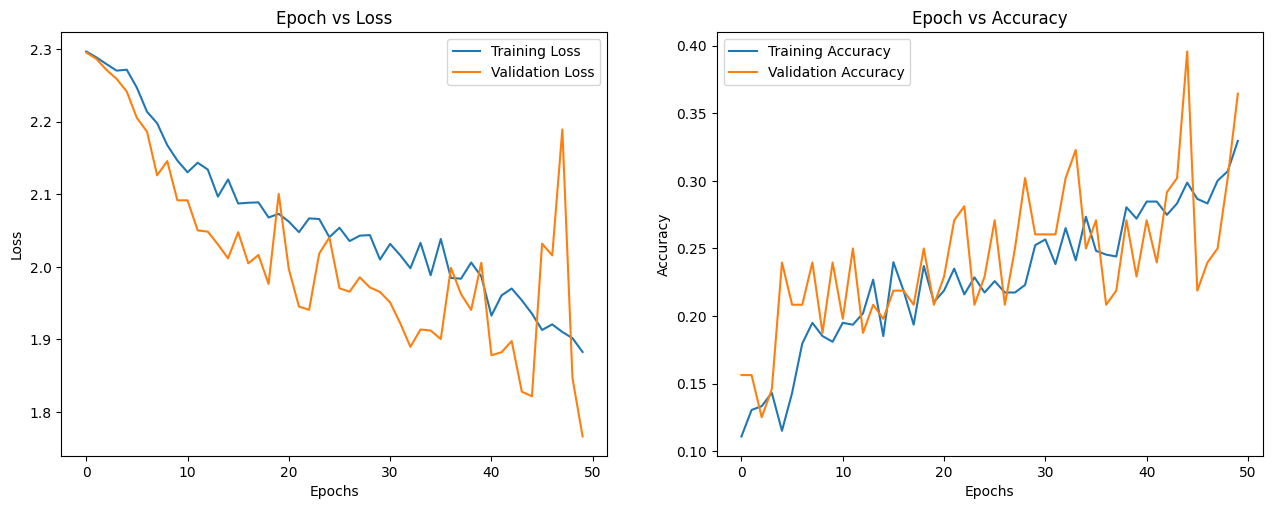

In [11]:
plot_loss_accuracy(train_loss, train_accuracy, val_loss, val_accuracy)

In [12]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [32]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

model.save('image_to_audio_model.h5')
# Load the saved model
model = load_model('image_to_audio_model.h5')

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((image_size[0], image_size[1]))
    
    # Convert 4-channel RGBA image to 3-channel RGB image
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Function to convert the predicted class index to audio class
def get_audio_class(class_index):
    audio_classes = ['blue', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    return audio_classes[class_index]

# Path to the input image
image_path = '/content/drive/MyDrive/Data/Data/images_original/rock/rock00000.png'

# Preprocess the image
image = preprocess_image(image_path)

# Perform the classification
predictions = model.predict(image)
predicted_class_index = np.argmax(predictions)
predicted_class = get_audio_class(predicted_class_index)

# Print the predicted audio class
print('Predicted Audio Class:', predicted_class)


1/1 [==============================] - 0s 99ms/step
Predicted Audio Class: metal


<ipython-input-18-82db49f15ec0>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


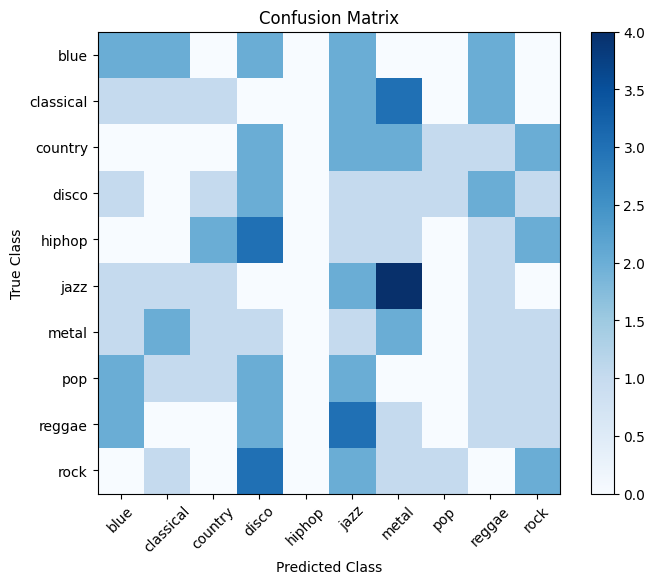

In [18]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('image_to_audio_model.h5')


# Predict the labels for the test data
predictions = model.predict_generator(test_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

audio_classes = ['blue', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(audio_classes))
plt.xticks(tick_marks, audio_classes, rotation=45)
plt.yticks(tick_marks, audio_classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
